In [26]:
import os
from glob import glob
import yaml
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import wilcoxon
from itertools import combinations

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

### Multiple seeds experiment

In [27]:
# Load scores from multiple runs with multiple seeds
dirpaths = glob('../experiments/data/outputs/seeds/mvn_experiment/seed_*')
scores = {'KRR-baseline':[], 'KRR-after':[], 'KRR-before':[]}
for dirpath in dirpaths:
    with open(os.path.join(dirpath, 'scores.metrics'), "r") as f:
        foo = yaml.safe_load(f)
        scores['KRR-baseline'].append(foo['baseline'])
        scores['KRR-after'].append(foo['after'])
        scores['KRR-before'].append(foo['before'])

with open('../experiments/data/outputs/seeds/mvn_experiment/RF/scores.metrics', "r") as f:
    foo = yaml.safe_load(f)
    scores['RF-baseline'] = foo['baseline']
    scores['RF-after'] = foo['after']

scores_df = pd.DataFrame(scores)
seeds_scores_df = scores_df.copy()

In [28]:
scores_df.columns = ['KRR', r'$P$-KRR', r'$\mathcal{H}_P$-KRR', 'RF', r'$P$-RF']
scores_df.aggregate(['mean', 'median', 'std'])

,KRR,$P$-KRR,$\mathcal{H}_P$-KRR,RF,$P$-RF
mean,0.238486,0.221210,0.206073,0.275385,0.266463
median,0.233671,0.219427,0.203442,0.266828,0.259937
std,0.037743,0.025511,0.023472,0.036857,0.036922


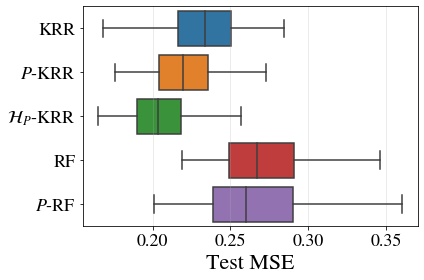

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.grid(alpha=0.3)
sns.boxplot(data=scores_df, orient='h', showfliers=False, ax=ax)

ax.set_xlabel("Test MSE", fontsize=22)
ax.set_yticklabels(['KRR', r'$P$-KRR', r'$\mathcal{H}_P$-KRR', 'RF', r'$P$-RF'])
ax.set_yticklabels(['KRR', r'$P$-KRR', r'$\mathcal{H}_P$-KRR', 'RF', r'$P$-RF'])
ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()

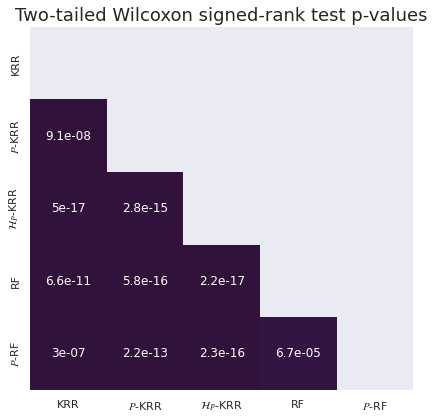

In [9]:
def paired_wilcoxon(df):
    cols = df.columns
    W_values = np.zeros((len(cols), len(cols)))
    p_values = np.zeros((len(cols), len(cols)))
    for i, j in combinations(range(len(cols)), 2):
        W, p = wilcoxon(x=df[cols[i]].values,
                        y=df[cols[j]].values)
        W_values[i, j] = W
        p_values[i, j] = p
    W_values =  W_values + W_values.T - np.eye(len(cols))
    p_values = p_values + p_values.T - np.eye(len(cols))
    W_df = pd.DataFrame(data=W_values, columns=cols, index=cols)
    p_df = pd.DataFrame(data=p_values, columns=cols, index=cols)
    return W_df, p_df

W_df, p_df_mse = paired_wilcoxon(scores_df)


sns.set(font_scale=1.)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
mask = np.zeros_like(p_df_mse, dtype=bool)
mask[np.triu_indices_from(mask)] = True
p_df_mse[mask] = np.nan
sns.heatmap(p_df_mse, cmap="turbo", annot=True, cbar=False, vmin=0, vmax=0.01, ax=ax) 
ax.set_title("Two-tailed Wilcoxon signed-rank test p-values", fontsize=18)
plt.tight_layout()
plt.show()

### n_train experiment

In [12]:
dirpaths = glob('../experiments/data/outputs/n_train/mvn_experiment/seed_*')
krr_scores = {'KRR-baseline':[], 'KRR-after':[], 'KRR-before':[], 'ntrain': [], 'seed': []}
for dirpath in dirpaths:
    tokens = dirpath.split('/')[-1].split('_')
    seed, ntrain = int(tokens[1]), float(tokens[-1])
    with open(os.path.join(dirpath, 'scores.metrics'), "r") as f:
        foo = yaml.safe_load(f)
        krr_scores['KRR-baseline'].append(foo['baseline'])
        krr_scores['KRR-after'].append(foo['after'])
        krr_scores['KRR-before'].append(foo['before'])
        krr_scores['ntrain'].append(ntrain)
        krr_scores['seed'].append(seed)
krr_scores_df = pd.DataFrame(krr_scores)
krr_scores_df[r'Gap $P$-KRR'] = krr_scores_df['KRR-baseline'] - krr_scores_df['KRR-after']
krr_scores_df[r'Gap $\mathcal{H}_P$-KRR'] = krr_scores_df['KRR-baseline'] - krr_scores_df['KRR-before']
krr_scores_df = krr_scores_df.drop('seed', axis=1).groupby('ntrain').aggregate(['mean', 'std'])


rf_scores = {'RF-baseline': [], 'RF-after': [], 'ntrain': [], 'seed': []}
with open('../experiments/data/outputs/n_train/mvn_experiment/RF/scores.metrics', "r") as f:
    foo = yaml.safe_load(f)
    rf_scores_df = pd.DataFrame(foo)
    rf_scores_df = rf_scores_df[['baseline', 'after', 'seed', 'n_train']]
    rf_scores_df.columns = ['RF-baseline', 'RF-after', 'seed', 'ntrain']
rf_scores_df[r'Gap $P$-RF'] = rf_scores_df['RF-baseline'] - rf_scores_df['RF-after']
rf_scores_df = rf_scores_df.drop('seed', axis=1).groupby('ntrain').aggregate(['mean', 'std'])

scores_df = pd.concat([krr_scores_df, rf_scores_df], axis=1)
ntrain_scores_df = scores_df.copy()

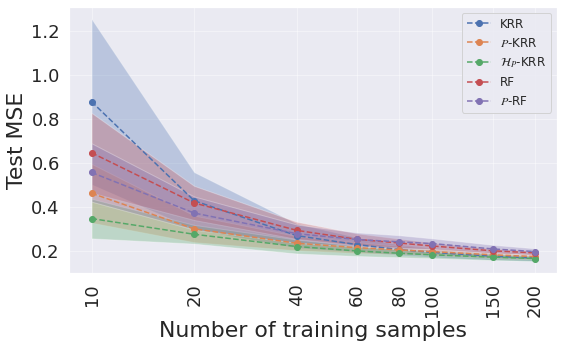

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fontsize = 22
legendsize = 12
labelsize = 18

ntrain = scores_df.index.values.astype(int)

KRR_baseline_mean = scores_df['KRR-baseline']['mean']
KRR_baseline_ub = KRR_baseline_mean + scores_df['KRR-baseline']['std']
KRR_baseline_lb = KRR_baseline_mean - scores_df['KRR-baseline']['std']

KRR_after_mean = scores_df['KRR-after']['mean']
KRR_after_ub = KRR_after_mean + scores_df['KRR-after']['std']
KRR_after_lb = KRR_after_mean - scores_df['KRR-after']['std']

KRR_before_mean = scores_df['KRR-before']['mean']
KRR_before_ub = KRR_before_mean + scores_df['KRR-before']['std']
KRR_before_lb = KRR_before_mean - scores_df['KRR-before']['std']

RF_baseline_mean = scores_df['RF-baseline']['mean']
RF_baseline_ub = RF_baseline_mean + scores_df['RF-baseline']['std']
RF_baseline_lb = RF_baseline_mean - scores_df['RF-baseline']['std']

RF_after_mean = scores_df['RF-after']['mean']
RF_after_ub = RF_after_mean + scores_df['RF-after']['std']
RF_after_lb = RF_after_mean - scores_df['RF-after']['std']


ax.plot(ntrain, KRR_baseline_mean, ls='--', marker='o', label='KRR')
ax.fill_between(ntrain, KRR_baseline_lb, KRR_baseline_ub, alpha=0.3)

ax.plot(ntrain, KRR_after_mean, ls='--', marker='o', label=r'$P$-KRR')
ax.fill_between(ntrain, KRR_after_lb, KRR_after_ub, alpha=0.3)

ax.plot(ntrain, KRR_before_mean, ls='--', marker='o', label=r'$\mathcal{H}_P$-KRR')
ax.fill_between(ntrain, KRR_before_lb, KRR_before_ub, alpha=0.3)

ax.plot(ntrain, RF_baseline_mean, ls='--', marker='o', label='RF')
ax.fill_between(ntrain, RF_baseline_lb, RF_baseline_ub, alpha=0.3)

ax.plot(ntrain, RF_after_mean, ls='--', marker='o', label=r'$P$-RF')
ax.fill_between(ntrain, RF_after_lb, RF_after_ub, alpha=0.3)

ax.set_xscale('log')
ax.set_xticks(ntrain)
ax.set_xticklabels(ntrain, rotation=90)
ax.tick_params(labelsize=12)

ax.set_ylabel("Test MSE", fontsize=fontsize)
ax.set_xlabel('Number of training samples', fontsize=fontsize)


ax.grid(alpha=0.4)
ax.tick_params(labelsize=labelsize)
plt.legend(fontsize=legendsize)
plt.tight_layout()
plt.show()

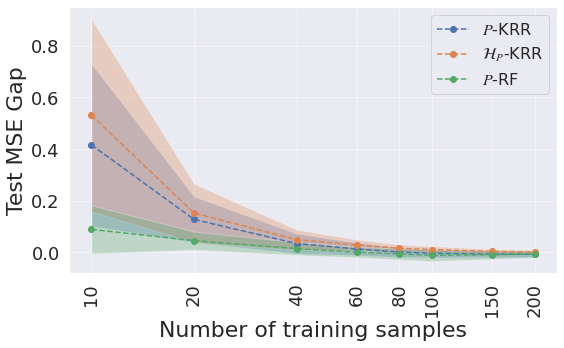

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fontsize = 22
legendsize = 16
labelsize = 18

ntrain = scores_df.index.values.astype(int)

KRR_after_mean = scores_df['Gap $P$-KRR']['mean']
KRR_after_ub = KRR_after_mean + scores_df['Gap $P$-KRR']['std']
KRR_after_lb = KRR_after_mean - scores_df['Gap $P$-KRR']['std']

KRR_before_mean = scores_df['Gap $\mathcal{H}_P$-KRR']['mean']
KRR_before_ub = KRR_before_mean + scores_df['Gap $\mathcal{H}_P$-KRR']['std']
KRR_before_lb = KRR_before_mean - scores_df['Gap $\mathcal{H}_P$-KRR']['std']

RF_after_mean = scores_df['Gap $P$-RF']['mean']
RF_after_ub = RF_after_mean + scores_df['Gap $P$-RF']['std']
RF_after_lb = RF_after_mean - scores_df['Gap $P$-RF']['std']


ax.plot(ntrain, KRR_after_mean, ls='--', marker='o', label=r'$P$-KRR')
ax.fill_between(ntrain, KRR_after_lb, KRR_after_ub, alpha=0.3)

ax.plot(ntrain, KRR_before_mean, ls='--', marker='o', label=r'$\mathcal{H}_P$-KRR')
ax.fill_between(ntrain, KRR_before_lb, KRR_before_ub, alpha=0.3)

ax.plot(ntrain, RF_after_mean, ls='--', marker='o', label=r'$P$-RF')
ax.fill_between(ntrain, RF_after_lb, RF_after_ub, alpha=0.3)

ax.set_xscale('log')
ax.set_xticks(ntrain)
ax.set_xticklabels(ntrain, rotation=90)
ax.tick_params(labelsize=12)

ax.set_ylabel("Test MSE Gap", fontsize=fontsize)
ax.set_xlabel('Number of training samples', fontsize=fontsize)


ax.grid(alpha=0.4)
ax.tick_params(labelsize=labelsize)
plt.legend(fontsize=legendsize)
plt.tight_layout()
plt.show()

### semi_prop

In [16]:
dirpaths = glob('../experiments/data/outputs/semi_prop/mvn_experiment/seed_*')
krr_scores = {'KRR-baseline':[], 'KRR-after':[], 'KRR-before':[], 'semi_prop': [], 'seed': []}
for dirpath in dirpaths:
    tokens = dirpath.split('/')[-1].split('_')
    seed, semi_prop = int(tokens[1]), float(tokens[-1])
    with open(os.path.join(dirpath, 'scores.metrics'), "r") as f:
        foo = yaml.safe_load(f)
        krr_scores['KRR-baseline'].append(foo['baseline'])
        krr_scores['KRR-after'].append(foo['after'])
        krr_scores['KRR-before'].append(foo['before'])
        krr_scores['semi_prop'].append(semi_prop)
        krr_scores['seed'].append(seed)
krr_scores_df = pd.DataFrame(krr_scores)
krr_scores_df[r'Gap $P$-KRR'] = krr_scores_df['KRR-baseline'] - krr_scores_df['KRR-after']
krr_scores_df[r'Gap $\mathcal{H}_P$-KRR'] = krr_scores_df['KRR-baseline'] - krr_scores_df['KRR-before']
krr_scores_df = krr_scores_df.drop('seed', axis=1).groupby('semi_prop').aggregate(['mean', 'std'])

rf_scores = {'RF-baseline': [], 'RF-after': [], 'semi_prop': [], 'seed': []}
with open('../experiments/data/outputs/semi_prop/mvn_experiment/RF/scores.metrics', "r") as f:
    foo = yaml.safe_load(f)
    rf_scores_df = pd.DataFrame(foo)
    rf_scores_df = rf_scores_df[['baseline', 'after', 'seed', 'semi_prop']]
    rf_scores_df.columns = ['RF-baseline', 'RF-after', 'seed', 'semi_prop']
rf_scores_df[r'Gap $P$-RF'] = rf_scores_df['RF-baseline'] - rf_scores_df['RF-after']
rf_scores_df = rf_scores_df.drop('seed', axis=1).groupby('semi_prop').aggregate(['mean', 'std'])

scores_df = pd.concat([krr_scores_df, rf_scores_df], axis=1)
semi_prop_scores_df = scores_df.copy()

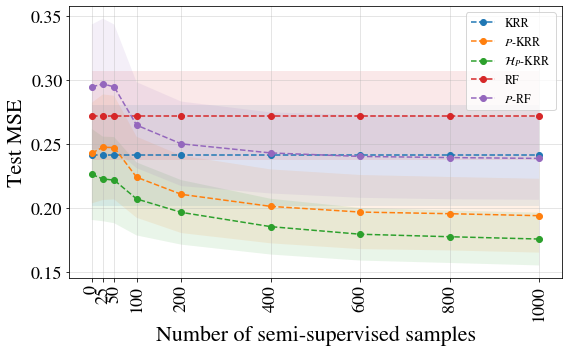

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fontsize = 22
legendsize = 12
labelsize = 18

semi_prop = scores_df.index.values.astype(int)

KRR_baseline_mean = scores_df['KRR-baseline']['mean']
KRR_baseline_ub = KRR_baseline_mean + scores_df['KRR-baseline']['std']
KRR_baseline_lb = KRR_baseline_mean - scores_df['KRR-baseline']['std']

KRR_after_mean = scores_df['KRR-after']['mean']
KRR_after_ub = KRR_after_mean + scores_df['KRR-after']['std']
KRR_after_lb = KRR_after_mean - scores_df['KRR-after']['std']

KRR_before_mean = scores_df['KRR-before']['mean']
KRR_before_ub = KRR_before_mean + scores_df['KRR-before']['std']
KRR_before_lb = KRR_before_mean - scores_df['KRR-before']['std']

RF_baseline_mean = scores_df['RF-baseline']['mean']
RF_baseline_ub = RF_baseline_mean + scores_df['RF-baseline']['std']
RF_baseline_lb = RF_baseline_mean - scores_df['RF-baseline']['std']

RF_after_mean = scores_df['RF-after']['mean']
RF_after_ub = RF_after_mean + scores_df['RF-after']['std']
RF_after_lb = RF_after_mean - scores_df['RF-after']['std']


ax.plot(semi_prop, KRR_baseline_mean, ls='--', marker='o', label='KRR')
ax.fill_between(semi_prop, KRR_baseline_lb, KRR_baseline_ub, alpha=0.1)

ax.plot(semi_prop, KRR_after_mean, ls='--', marker='o', label=r'$P$-KRR')
ax.fill_between(semi_prop, KRR_after_lb, KRR_after_ub, alpha=0.1)

ax.plot(semi_prop, KRR_before_mean, ls='--', marker='o', label=r'$\mathcal{H}_P$-KRR')
ax.fill_between(semi_prop, KRR_before_lb, KRR_before_ub, alpha=0.1)

ax.plot(semi_prop, RF_baseline_mean, ls='--', marker='o', label='RF')
ax.fill_between(semi_prop, RF_baseline_lb, RF_baseline_ub, alpha=0.1)

ax.plot(semi_prop, RF_after_mean, ls='--', marker='o', label=r'$P$-RF')
ax.fill_between(semi_prop, RF_after_lb, RF_after_ub, alpha=0.1)

# ax.set_xscale('log')
ax.set_xticks(semi_prop)
ax.set_xticklabels(semi_prop, rotation=90)
ax.tick_params(labelsize=12)

ax.set_ylabel("Test MSE", fontsize=fontsize)
ax.set_xlabel('Number of semi-supervised samples', fontsize=fontsize)


ax.grid(alpha=0.4)
ax.tick_params(labelsize=labelsize)
plt.legend(fontsize=legendsize)
plt.tight_layout()
plt.show()

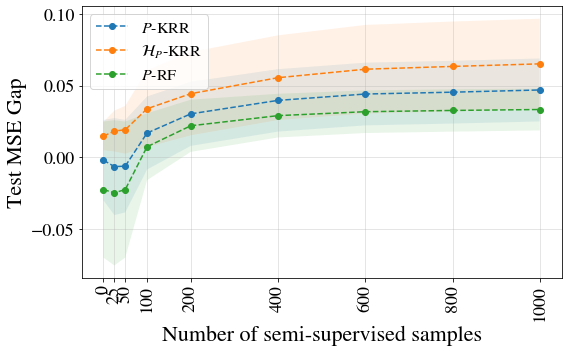

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fontsize = 22
legendsize = 16
labelsize = 18

semi_prop = scores_df.index.values.astype(int)

KRR_after_mean = scores_df['Gap $P$-KRR']['mean']
KRR_after_ub = KRR_after_mean + scores_df['Gap $P$-KRR']['std']
KRR_after_lb = KRR_after_mean - scores_df['Gap $P$-KRR']['std']

KRR_before_mean = scores_df['Gap $\mathcal{H}_P$-KRR']['mean']
KRR_before_ub = KRR_before_mean + scores_df['Gap $\mathcal{H}_P$-KRR']['std']
KRR_before_lb = KRR_before_mean - scores_df['Gap $\mathcal{H}_P$-KRR']['std']

RF_after_mean = scores_df['Gap $P$-RF']['mean']
RF_after_ub = RF_after_mean + scores_df['Gap $P$-RF']['std']
RF_after_lb = RF_after_mean - scores_df['Gap $P$-RF']['std']


ax.plot(semi_prop, KRR_after_mean, ls='--', marker='o', label=r'$P$-KRR')
ax.fill_between(semi_prop, KRR_after_lb, KRR_after_ub, alpha=0.1)

ax.plot(semi_prop, KRR_before_mean, ls='--', marker='o', label=r'$\mathcal{H}_P$-KRR')
ax.fill_between(semi_prop, KRR_before_lb, KRR_before_ub, alpha=0.1)

ax.plot(semi_prop, RF_after_mean, ls='--', marker='o', label=r'$P$-RF')
ax.fill_between(semi_prop, RF_after_lb, RF_after_ub, alpha=0.1)

ax.set_xticks(semi_prop)
ax.set_xticklabels(semi_prop, rotation=90)
ax.tick_params(labelsize=12)

ax.set_ylabel("Test MSE Gap", fontsize=fontsize)
ax.set_xlabel('Number of semi-supervised samples', fontsize=fontsize)


ax.grid(alpha=0.4)
ax.tick_params(labelsize=labelsize)
plt.legend(fontsize=legendsize)
plt.tight_layout()
plt.show()

### Dim $X_2$

In [18]:
dirpaths = glob('../experiments/data/outputs/d_X2/mvn_experiment/seed_*')
krr_scores = {'KRR-baseline':[], 'KRR-after':[], 'KRR-before':[], 'd_X2': [], 'seed': []}
for dirpath in dirpaths:
    tokens = dirpath.split('/')[-1].split('_')
    seed, semi_prop = int(tokens[1]), float(tokens[-1])
    with open(os.path.join(dirpath, 'scores.metrics'), "r") as f:
        foo = yaml.safe_load(f)
        krr_scores['KRR-baseline'].append(foo['baseline'])
        krr_scores['KRR-after'].append(foo['after'])
        krr_scores['KRR-before'].append(foo['before'])
        krr_scores['d_X2'].append(semi_prop)
        krr_scores['seed'].append(seed)
krr_scores_df = pd.DataFrame(krr_scores)
krr_scores_df[r'Gap $P$-KRR'] = krr_scores_df['KRR-baseline'] - krr_scores_df['KRR-after']
krr_scores_df[r'Gap $\mathcal{H}_P$-KRR'] = krr_scores_df['KRR-baseline'] - krr_scores_df['KRR-before']
krr_scores_df = krr_scores_df.drop('seed', axis=1).groupby('d_X2').aggregate(['mean', 'std'])


rf_scores = {'RF-baseline': [], 'RF-after': [], 'd_X2': [], 'seed': []}
with open('../experiments/data/outputs/d_X2/mvn_experiment/RF/scores.metrics', "r") as f:
    foo = yaml.safe_load(f)
    rf_scores_df = pd.DataFrame(foo)
    rf_scores_df = rf_scores_df[['baseline', 'after', 'seed', 'd_X2']]
    rf_scores_df.columns = ['RF-baseline', 'RF-after', 'seed', 'd_X2']
rf_scores_df[r'Gap $P$-RF'] = rf_scores_df['RF-baseline'] - rf_scores_df['RF-after']
rf_scores_df = rf_scores_df.drop('seed', axis=1).groupby('d_X2').aggregate(['mean', 'std'])

scores_df = pd.concat([krr_scores_df, rf_scores_df], axis=1)
d_X2_scores_df = scores_df.copy()

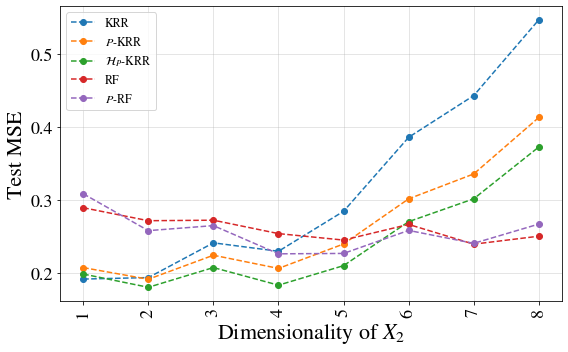

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fontsize = 22
legendsize = 12
labelsize = 18

d_X2 = scores_df.index.values.astype(int)

KRR_baseline_mean = scores_df['KRR-baseline']['mean']
KRR_baseline_ub = KRR_baseline_mean + scores_df['KRR-baseline']['std']
KRR_baseline_lb = KRR_baseline_mean - scores_df['KRR-baseline']['std']

KRR_after_mean = scores_df['KRR-after']['mean']
KRR_after_ub = KRR_after_mean + scores_df['KRR-after']['std']
KRR_after_lb = KRR_after_mean - scores_df['KRR-after']['std']

KRR_before_mean = scores_df['KRR-before']['mean']
KRR_before_ub = KRR_before_mean + scores_df['KRR-before']['std']
KRR_before_lb = KRR_before_mean - scores_df['KRR-before']['std']

RF_baseline_mean = scores_df['RF-baseline']['mean']
RF_baseline_ub = RF_baseline_mean + scores_df['RF-baseline']['std']
RF_baseline_lb = RF_baseline_mean - scores_df['RF-baseline']['std']

RF_after_mean = scores_df['RF-after']['mean']
RF_after_ub = RF_after_mean + scores_df['RF-after']['std']
RF_after_lb = RF_after_mean - scores_df['RF-after']['std']


ax.plot(d_X2, KRR_baseline_mean, ls='--', marker='o', label='KRR')
# ax.fill_between(d_X2, KRR_baseline_lb, KRR_baseline_ub, alpha=0.3)

ax.plot(d_X2, KRR_after_mean, ls='--', marker='o', label=r'$P$-KRR')
# ax.fill_between(d_X2, KRR_after_lb, KRR_after_ub, alpha=0.3)

ax.plot(d_X2, KRR_before_mean, ls='--', marker='o', label=r'$\mathcal{H}_P$-KRR')
# ax.fill_between(d_X2, KRR_before_lb, KRR_before_ub, alpha=0.3)

ax.plot(d_X2, RF_baseline_mean, ls='--', marker='o', label='RF')
# ax.fill_between(d_X2, RF_baseline_lb, RF_baseline_ub, alpha=0.3)

ax.plot(d_X2, RF_after_mean , ls='--', marker='o', label=r'$P$-RF')
# ax.fill_between(d_X2, RF_after_lb, RF_after_ub, alpha=0.3)

# ax.set_xscale('log')
ax.set_xticks(d_X2)
ax.set_xticklabels(d_X2, rotation=90)
ax.tick_params(labelsize=12)

ax.set_ylabel("Test MSE", fontsize=fontsize)
ax.set_xlabel(r'Dimensionality of $X_2$', fontsize=fontsize)


ax.grid(alpha=0.4)
ax.tick_params(labelsize=labelsize)
plt.legend(fontsize=legendsize)
plt.tight_layout()
plt.show()

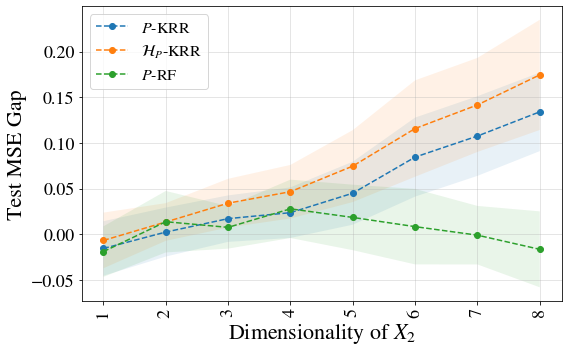

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fontsize = 22
legendsize = 16
labelsize = 18

d_X2 = scores_df.index.values.astype(int)

KRR_after_mean = scores_df['Gap $P$-KRR']['mean']
KRR_after_ub = KRR_after_mean + scores_df['Gap $P$-KRR']['std']
KRR_after_lb = KRR_after_mean - scores_df['Gap $P$-KRR']['std']

KRR_before_mean = scores_df['Gap $\mathcal{H}_P$-KRR']['mean']
KRR_before_ub = KRR_before_mean + scores_df['Gap $\mathcal{H}_P$-KRR']['std']
KRR_before_lb = KRR_before_mean - scores_df['Gap $\mathcal{H}_P$-KRR']['std']

RF_after_mean = scores_df['Gap $P$-RF']['mean']
RF_after_ub = RF_after_mean + scores_df['Gap $P$-RF']['std']
RF_after_lb = RF_after_mean - scores_df['Gap $P$-RF']['std']


ax.plot(d_X2, KRR_after_mean, ls='--', marker='o', label=r'$P$-KRR')
ax.fill_between(d_X2, KRR_after_lb, KRR_after_ub, alpha=0.1)

ax.plot(d_X2, KRR_before_mean, ls='--', marker='o', label=r'$\mathcal{H}_P$-KRR')
ax.fill_between(d_X2, KRR_before_lb, KRR_before_ub, alpha=0.1)

ax.plot(d_X2, RF_after_mean, ls='--', marker='o', label=r'$P$-RF')
ax.fill_between(d_X2, RF_after_lb, RF_after_ub, alpha=0.1)

ax.set_xticks(d_X2)
ax.set_xticklabels(d_X2, rotation=90)
ax.tick_params(labelsize=12)

ax.set_ylabel("Test MSE Gap", fontsize=fontsize)
ax.set_xlabel(r'Dimensionality of $X_2$', fontsize=fontsize)


ax.grid(alpha=0.4)
ax.tick_params(labelsize=labelsize)
plt.legend(fontsize=legendsize)
plt.tight_layout()
plt.show()

## Paper plot

In [38]:
def get_mean_lb_ub(scores_df):
    KRR_after_mean = scores_df['Gap $P$-KRR']['mean']
    KRR_after_ub = KRR_after_mean + scores_df['Gap $P$-KRR']['std']
    KRR_after_lb = KRR_after_mean - scores_df['Gap $P$-KRR']['std']
    KRR_after = {'mean': KRR_after_mean,
                 'ub': KRR_after_ub,
                 'lb': KRR_after_lb}

    KRR_before_mean = scores_df['Gap $\mathcal{H}_P$-KRR']['mean']
    KRR_before_ub = KRR_before_mean + scores_df['Gap $\mathcal{H}_P$-KRR']['std']
    KRR_before_lb = KRR_before_mean - scores_df['Gap $\mathcal{H}_P$-KRR']['std']
    KRR_before = {'mean': KRR_before_mean,
                  'ub': KRR_before_ub,
                  'lb': KRR_before_lb}

    RF_after_mean = scores_df['Gap $P$-RF']['mean']
    RF_after_ub = RF_after_mean + scores_df['Gap $P$-RF']['std']
    RF_after_lb = RF_after_mean - scores_df['Gap $P$-RF']['std']
    RF_after = {'mean': RF_after_mean,
                'ub': RF_after_ub,
                'lb': RF_after_lb}
    
    output = {'KRR-after': KRR_after, 'KRR-before': KRR_before, 'RF-after': RF_after}
    return output

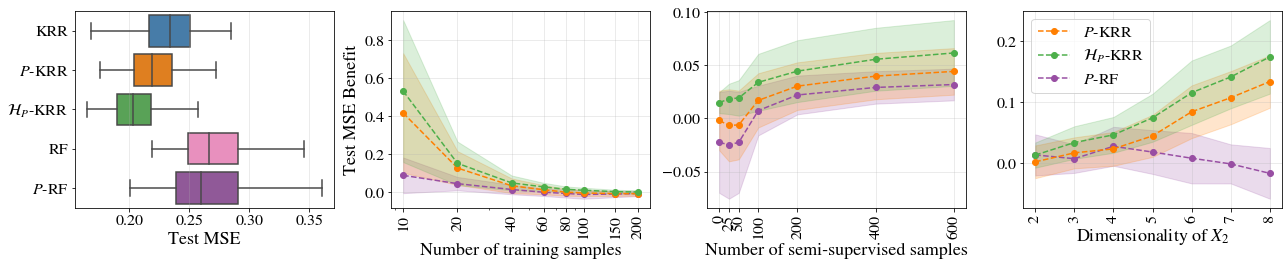

In [86]:
fig, ax = plt.subplots(1, 4, figsize=(18, 3.8))

fontsize = 18
legendsize = 16
labelsize = 16
alpha = 0.2
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#984ea3', '#a65628',
                  '#999999', '#e41a1c', '#dede00']
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=CB_color_cycle)

# Boxplot
ax[0].grid(alpha=0.3)
sns.boxplot(data=seeds_scores_df, orient='h', showfliers=False, ax=ax[0])
ax[0].set_xlabel("Test MSE", fontsize=fontsize)
ax[0].set_yticklabels(['KRR', r'$P$-KRR', r'$\mathcal{H}_P$-KRR', 'RF', r'$P$-RF'])
ax[0].tick_params(labelsize=labelsize)

# ntrain
ntrain = ntrain_scores_df.index.values.astype(int)
output = get_mean_lb_ub(ntrain_scores_df)

ax[1].plot(ntrain, output['RF-after']['mean'], 
           ls='--', marker='o', label=r'$P$-RF', color=CB_color_cycle[4])
ax[1].fill_between(ntrain, output['RF-after']['lb'], output['RF-after']['ub'], 
                   alpha=alpha, color=CB_color_cycle[4])

ax[1].plot(ntrain, output['KRR-after']['mean'], 
           ls='--', marker='o', label=r'$P$-KRR', color=CB_color_cycle[1])
ax[1].fill_between(ntrain, output['KRR-after']['lb'], output['KRR-after']['ub'], 
                   alpha=alpha, color=CB_color_cycle[1])

ax[1].plot(ntrain, output['KRR-before']['mean'], 
           ls='--', marker='o', label=r'$\mathcal{H}_P$-KRR', color=CB_color_cycle[2])
ax[1].fill_between(ntrain, output['KRR-before']['lb'], output['KRR-before']['ub'], 
                   alpha=alpha, color=CB_color_cycle[2])

ax[1].set_xscale('log')
ax[1].set_xticks(ntrain)
ax[1].set_xticklabels(ntrain, rotation=90)
ax[1].tick_params(labelsize=labelsize)

ax[1].set_ylabel("Test MSE Benefit", fontsize=fontsize)
ax[1].set_xlabel('Number of training samples', fontsize=fontsize)

ax[1].grid(alpha=0.3)
ax[1].tick_params(labelsize=labelsize)
# ax[1].legend(fontsize=legendsize)


# semi_prop
semi_prop = semi_prop_scores_df.iloc[:-2].index.values.astype(int)
output = get_mean_lb_ub(semi_prop_scores_df.iloc[:-2])

ax[2].plot(semi_prop, output['RF-after']['mean'], 
           ls='--', marker='o', label=r'$P$-RF', color=CB_color_cycle[4])
ax[2].fill_between(semi_prop, output['RF-after']['lb'], output['RF-after']['ub'], 
                   alpha=alpha, color=CB_color_cycle[4])

ax[2].plot(semi_prop, output['KRR-after']['mean'], 
           ls='--', marker='o', label=r'$P$-KRR', color=CB_color_cycle[1])
ax[2].fill_between(semi_prop, output['KRR-after']['lb'], output['KRR-after']['ub'], 
                   alpha=alpha, color=CB_color_cycle[1])

ax[2].plot(semi_prop, output['KRR-before']['mean'], 
           ls='--', marker='o', label=r'$\mathcal{H}_P$-KRR', color=CB_color_cycle[2])
ax[2].fill_between(semi_prop, output['KRR-before']['lb'], output['KRR-before']['ub'], 
                   alpha=alpha, color=CB_color_cycle[2])


ax[2].set_xticks(semi_prop)
ax[2].set_xticklabels(semi_prop, rotation=90)
ax[2].tick_params(labelsize=labelsize)

ax[2].set_xlabel('Number of semi-supervised samples', fontsize=fontsize)

ax[2].grid(alpha=0.3)
ax[2].tick_params(labelsize=labelsize)
# ax[2].legend(fontsize=legendsize)


# dX2
d_X2 = d_X2_scores_df.iloc[1:].index.values.astype(int)
output = get_mean_lb_ub(d_X2_scores_df.iloc[1:])

ax[3].plot(d_X2, output['RF-after']['mean'], 
           ls='--', marker='o', label=r'$P$-RF', color=CB_color_cycle[4])
ax[3].fill_between(d_X2, output['RF-after']['lb'], output['RF-after']['ub'], 
                   alpha=alpha, color=CB_color_cycle[4])

ax[3].plot(d_X2, output['KRR-after']['mean'], 
           ls='--', marker='o', label=r'$P$-KRR', color=CB_color_cycle[1])
ax[3].fill_between(d_X2, output['KRR-after']['lb'], output['KRR-after']['ub'], 
                   alpha=alpha, color=CB_color_cycle[1])

ax[3].plot(d_X2, output['KRR-before']['mean'], 
           ls='--', marker='o', label=r'$\mathcal{H}_P$-KRR', color=CB_color_cycle[2])
ax[3].fill_between(d_X2, output['KRR-before']['lb'], output['KRR-before']['ub'], 
                   alpha=alpha, color=CB_color_cycle[2])


ax[3].set_xticks(d_X2)
ax[3].set_xticklabels(d_X2, rotation=90)
ax[3].tick_params(labelsize=labelsize)

ax[3].set_xlabel(r'Dimensionality of $X_2$', fontsize=fontsize)

ax[3].grid(alpha=0.3)
ax[3].tick_params(labelsize=labelsize)
ax[3].legend()
handles, labels = ax[3].get_legend_handles_labels()
ax[3].legend([handles[1], handles[2], handles[0]],
             [labels[1], labels[2], labels[0]],
             fontsize=legendsize)

plt.tight_layout()
plt.savefig('simulation-results.png', dpi=300)
plt.show()